In [2]:
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from numpy.typing import ArrayLike
from scipy.optimize import rosen, rosen_der

## Test-Functions

In [85]:
# ====================================================================
# Quadratic kernel functions
def mk_quad(epsilon, ndim=2):
    def f(x, eps=epsilon):
        x = np.asarray(x)
        epsilon = np.asarray(eps, dtype=x.dtype)
        y = x.copy()
        y *= np.power(epsilon, np.arange(ndim))
        return 1/ndim * np.sum(y**2)

    def f_prime(x, eps=epsilon):
        x = np.asarray(x)
        epsilon = np.asarray(eps, dtype=x.dtype)
        y = x.copy()
        scaling = np.power(epsilon, np.arange(ndim))
        y *= scaling
        return 2/ndim * scaling * y
    
    return f, f_prime

def mk_quad_torch(epsilon, ndim=2):
    def f(x, eps=epsilon):
        y = x.clone()
        y *= torch.pow(epsilon, torch.arange(ndim, dtype=torch.float32))
        return 1/ndim * torch.sum(y**2)

    def f_prime(x, eps=epsilon):
        y = x.clone()
        scaling = torch.pow(epsilon, torch.arange(ndim, dtype=torch.float32))
        y *= scaling
        return 2/ndim * scaling * y  # Convert back to NumPy array for compatibility
    
    return f, f_prime

# ====================================================================
# Non-convex Gaussian kernel functions
def gaussian(x):
    return np.exp(-np.sum(x**2))

def gaussian_prime(x):
    return -2 * x * np.exp(-np.sum(x**2))

def mk_gauss(epsilon, ndim=2):
    def f(x):
        x = np.asarray(x)
        y = x.copy()
        y *= np.power(epsilon, np.arange(ndim))
        return 1 - gaussian(.5 * y)

    def f_prime(x):
        x = np.asarray(x)
        y = x.copy()
        scaling = np.power(epsilon, np.arange(ndim))
        y *= scaling
        return -.5 * scaling * gaussian_prime(.5 * y)
    
    return f, f_prime

def gaussian_torch(x):
    return torch.exp(-torch.sum(x**2))

def gaussian_prime_torch(x):
    return -2 * x * torch.exp(-torch.sum(x**2))

def mk_gauss_torch(epsilon, ndim=2):
    def f(x):
        y = x.clone()
        y *= torch.pow(epsilon, torch.arange(ndim).float())
        return -gaussian_torch(.5 * y) + 1

    def f_prime(x):
        y = x.clone()
        scaling = torch.pow(epsilon, torch.arange(ndim).float())
        y *= scaling
        return -.5 * scaling * gaussian_prime_torch(.5 * y)
    
    return f, f_prime

# ====================================================================
# Ill-condition problem: Rosenbrock function (flat region)
def rosenbrock_torch(x):
    return torch.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0, dim=0)

# ====================================================================
# Ill-condition problem: EggHolder (Local Minima)
def mk_eggholder():
    def f(x):
        x = np.asarray(x)
        y = x.copy()
        return (
            -(y[1] + 47) * np.sin(np.sqrt(np.abs(y[0]/2 + (y[1] + 47)))) 
            - y[0] * np.sin(np.sqrt(np.abs(y[0] - (y[1] + 47))))
        )

    def f_prime(x):
        x = np.asarray(x)
        y = x.copy()
        sqrt_abs_term = np.sqrt(np.abs(y[0]/2 + (y[1] + 47)))
        sin_term = np.sin(sqrt_abs_term)
        common_part = np.exp(-sqrt_abs_term) * np.sqrt(np.abs(y[0]/2 + (y[1] + 47)))
        
        gradient_x0 = (
            -sin_term * np.sign(y[0]) * common_part 
            - np.sin(sqrt_abs_term) * np.sign(y[0]) * common_part
        )
        gradient_x1 = (
            -np.sin(sqrt_abs_term) * common_part
            -np.exp(-sqrt_abs_term) * np.sign(y[1] + 47) * sin_term * common_part
        )
        
        return np.array([gradient_x0, gradient_x1])
    
    return f, f_prime

def mk_eggholder_torch():
    def f(x):
        x = torch.tensor(x, dtype=torch.float64)
        y = x.clone()
        return -(y[1] + 47) * torch.sin(torch.sqrt(torch.abs(y[0]/2 + (y[1] + 47)))) - y[0] * torch.sin(torch.sqrt(torch.abs(y[0] - (y[1] + 47))))

    def f_prime(x):
        x = torch.tensor(x, dtype=torch.float64)
        y = x.clone()
        sqrt_abs_term = torch.sqrt(torch.abs(y[0]/2 + (y[1] + 47)))
        sin_term = torch.sin(sqrt_abs_term)
        common_part = torch.exp(-sqrt_abs_term) * torch.sqrt(torch.abs(y[0]/2 + (y[1] + 47)))
        
        gradient_x0 = -sin_term * torch.sign(y[0]) * common_part - torch.sin(sqrt_abs_term) * torch.sign(y[0]) * common_part
        gradient_x1 = -torch.sin(sqrt_abs_term) * common_part - torch.exp(-sqrt_abs_term) * torch.sign(y[1] + 47) * sin_term * common_part
        
        return torch.tensor([gradient_x0.item(), gradient_x1.item()], dtype=torch.float32)
    
    return f, f_prime


In [86]:
# Example usage for quadratic functions
epsilon_quad = 0.1
ndim_quad = 2
f_quad, f_prime_quad = mk_quad(epsilon_quad, ndim_quad)
f_quad_torch, f_prime_quad_torch = mk_quad_torch(epsilon_quad, ndim_quad)

x_example_quad = np.array([1.0, 2.0])

result_quad = f_quad(x_example_quad)
gradient_quad = f_prime_quad(x_example_quad)
print("Quadratic Function Result:", result_quad)
print("Quadratic Function Gradient:", gradient_quad)

result_quad_torch = f_quad_torch(torch.tensor(x_example_quad))
gradient_quad_torch = f_prime_quad_torch(torch.tensor(x_example_quad))
print("Quadratic Function (Torch) Result:", result_quad_torch.item())
print("Quadratic Function (Torch) Gradient:", gradient_quad_torch.detach().numpy())

# Example usage for Gaussian functions
epsilon_gauss = 0.1
ndim_gauss = 2
f_gauss, f_prime_gauss = mk_gauss(epsilon_gauss, ndim_gauss)
f_gauss_torch, f_prime_gauss_torch = mk_gauss_torch(epsilon_gauss, ndim_gauss)

print("======================================")
x_example_gauss = np.array([1.0, 2.0])

result_gauss = f_gauss(x_example_gauss)
gradient_gauss = f_prime_gauss(x_example_gauss)
print("Gaussian Function Result:", result_gauss)
print("Gaussian Function Gradient:", gradient_gauss)

result_gauss_torch = f_gauss_torch(torch.tensor(x_example_gauss))
gradient_gauss_torch = f_prime_gauss_torch(torch.tensor(x_example_gauss))
print("Gaussian Function (Torch) Result:", result_gauss_torch.item())
print("Gaussian Function (Torch) Gradient:", gradient_gauss_torch.detach().numpy())

# Example usage for Eggholder function
print("======================================")
f_eggholder, f_prime_eggholder = mk_eggholder()
f_eggholder_torch, f_prime_eggholder_torch = mk_eggholder_torch()

x_example_eggholder = np.array([512.0, 404.2319])

result_eggholder = f_eggholder(x_example_eggholder)
gradient_eggholder = f_prime_eggholder(x_example_eggholder)
print("Eggholder Function Result:", result_eggholder)
print("Eggholder Function Gradient:", gradient_eggholder)

result_eggholder_torch = f_eggholder_torch(x_example_eggholder)
gradient_eggholder_torch = f_prime_eggholder_torch(x_example_eggholder)
print("Eggholder Function (Torch) Result:", result_eggholder_torch.item())
print("Eggholder Function (Torch) Gradient:", gradient_eggholder_torch.numpy())


Quadratic Function Result: 0.52
Quadratic Function Gradient: [1.   0.02]
Quadratic Function (Torch) Result: 0.5200000005960465
Quadratic Function (Torch) Gradient: [1.   0.02]
Gaussian Function Result: 0.22894841419643375
Gaussian Function Gradient: [0.38552579 0.00771052]
Gaussian Function (Torch) Result: 0.22894841442622504
Gaussian Function (Torch) Gradient: [0.38552579 0.00771052]
Eggholder Function Result: -959.6406627106155
Eggholder Function Gradient: [-1.49154972e-10 -7.45774862e-11]
Eggholder Function (Torch) Result: -959.6406627106155
Eggholder Function (Torch) Gradient: [-1.4915497e-10 -7.4577483e-11]


## Adam Optimizer

In [9]:
class AdamOptimizer():
    def __init__(self,
        lr: float=0.001,
        beta1: float=0.9,
        beta2: float=0.999,
        epsilon: float=1e-8,
        use_ema: bool=False
    ) -> None:
        self.learning_rate = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.use_ema = use_ema
        self.momentums: Optional[ArrayLike] = None
        self.velocities: Optional[ArrayLike] = None
        self.all_x_k: Optional[List[ArrayLike]] = None
        self.all_f_k: Optional[List[float]] = None
        self.iter = 0

    def initialize(self, var: ArrayLike) -> None:
        self.momentums = np.zeros_like(var)
        self.velocities = np.zeros_like(var)
        self.all_x_k = []
        self.all_f_k = []
        self.iter = 0
        self.initial_guess = var
        
    def update_step(self, theta: ArrayLike, f, f_grad, f_grad_args=()) -> Tuple[ArrayLike, float, ArrayLike]:
        theta_old = theta.copy()
        self.iter += 1
        beta1_power = np.power(self.beta1, self.iter, dtype=theta.dtype)
        beta2_power = np.power(self.beta2, self.iter, dtype=theta.dtype)

        # Update rule.
        grad = f_grad(theta, *f_grad_args)
        self.momentums = self.beta1 * self.momentums + (1 - self.beta1) * grad
        self.velocities = self.beta2 * self.velocities + (1 - self.beta2) * grad**2
        alpha = self.learning_rate * np.sqrt(1 - beta2_power) / (1 - beta1_power)
        theta -= alpha * self.momentums / (np.sqrt(self.velocities) + self.epsilon)

        # Exponential moving average (EMA).
        if self.use_ema:
            theta = self.beta1 * theta_old + (1 - self.beta1) * theta

        return theta, f(theta), grad

    def minimize(self, theta_init: ArrayLike, f, f_grad, f_grad_args=(), max_iter=1000) -> ArrayLike:
        theta = theta_init.copy()

        if self.iter == 0:
            self.initialize(theta)

        self.all_x_k.append(theta.copy())
        self.all_f_k.append(f(theta))

        for _ in range(max_iter):
            theta, f_theta, grad_theta = self.update_step(
                theta, 
                f=f,
                f_grad=f_grad,
                f_grad_args=f_grad_args
            )
            self.all_x_k.append(theta.copy())
            self.all_f_k.append(f_theta.copy())

            # Alternative stopping criteria.
            l_inf_norm_grad = np.max(np.abs(grad_theta))
            if l_inf_norm_grad < 1e-6:
                break

        return theta, f(theta), f_grad(theta)

    def get_config(self):
        return {
            "learning_rate": self.learning_rate,
            "beta_1": self.beta1,
            "beta_2": self.beta2,
            "epsilon": self.epsilon,
            "use_ema": self.use_ema
        }

In [13]:
from src.algorithms.adam import AdamOptimizer
np.random.seed(42)
initial_guess = np.random.random(2); print(initial_guess)
objective_function, gradient_function = mk_quad(0.5, ndim=2)
adam_optimizer = AdamOptimizer(45)
adam_optimizer.initialize(initial_guess)
adam_optimizer.minimize(initial_guess, objective_function, gradient_function)
# adam_optimizer.all_x_k, adam_optimizer.all_f_k,

[0.37454012 0.95071431]


(array([ 4.03955424e-06, -2.63601327e-07]),
 8.167684955691767e-12,
 array([ 4.03955424e-06, -6.59003319e-08]))

## Wrapper for Optimizers

In [53]:
def simple_optimize_torch(optimizer_cls, x_init, loss_fn, optim_kwargs={}, max_iter=100, grad_threshold=1e-6):
    x_init_ = torch.tensor(x_init, dtype=torch.float64, requires_grad=True)
    x = x_init_.clone().detach().requires_grad_(True)
    optimizer = optimizer_cls([x], **optim_kwargs)

    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_fn(x)
        loss.backward()
        optimizer.step()

        grad = x.grad.detach().numpy().copy()
        if np.min(np.abs(grad)) < grad_threshold:
            break

    return x.detach().numpy().copy(), loss_fn(x).detach().numpy().copy()

In [233]:
def optimize_torch(optimizer_cls, x_init, loss_fn, optim_kwargs={}, max_iter=100, grad_threshold=1e-16):
    x_init_ = torch.tensor(x_init, dtype=torch.float64, requires_grad=True)
    x = x_init_.clone().detach().requires_grad_(True)
    optimizer = optimizer_cls([x], **optim_kwargs)
    all_x_k = [x.detach().numpy().copy()]
    all_f_k = [loss_fn(x).item()]

    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_fn(x)
        loss.backward()
        optimizer.step()

        all_x_k.append(x.detach().numpy().copy())
        all_f_k.append(loss.item())
        grad = x.grad.detach().numpy().copy()

        if np.min(np.abs(grad)) < grad_threshold:
            break

    return np.array(all_x_k), np.array(all_f_k)

np.random.seed(42)
x0 = np.array([1.6, 1.1])
x_init = np.random.rand(2)
print(x_init)
# Example usage:
solutions, images = optimize_torch(
    optim.SGD,
    x_init=x_init, 
    loss_fn=rosenbrock_torch,
    optim_kwargs={"lr": 1e-4, "nesterov": True, "momentum": 0.99, "dampening": 0.}, max_iter=1000)

print("Final Solution:", solutions[-1], len(solutions))
print("Final Value:", images[-1])

[0.37454012 0.95071431]
Final Solution: [1.00872162 1.01755387] 1001
Final Value: 7.767353342179023e-05


In [153]:
def optimize_function(x_init, loss_fn, f, f_grad, adam_local_kw={}, adam_torch_kw={}, adagrad_kw={}, rmsprop_kw={}, sgd_nesterov_kw={}, max_iter=1000):
    optimizers = {
        "Adam (Torch)": (optim.Adam, adam_torch_kw),
        "Adagrad": (optim.Adagrad, adagrad_kw),
        "RMSprop": (optim.RMSprop, rmsprop_kw),
        "SGD-Nesterov": (optim.SGD, sgd_nesterov_kw)
    }
    solutions, values = {}, {}
    for optim_name, (optim_cls, optim_kwargs) in optimizers.items():    
        solutions[optim_name], values[optim_name] = optimize_torch(
            optim_cls,
            x_init=x_init,
            loss_fn=loss_fn,
            optim_kwargs=optim_kwargs,
            max_iter=max_iter
        )
    adam_optim = AdamOptimizer(**adam_local_kw)
    adam_optim.minimize(theta_init=x_init, f=f, f_grad=f_grad, f_grad_args=(), max_iter=1000)
    solutions["Adam (Local)"] = np.array(adam_optim.all_x_k) 
    values["Adam (Local)"] = np.array(adam_optim.all_f_k)

    return solutions, values

In [155]:
def tune_parameters(optim_cls, x_init, x_star, f_star, loss_fn, hyperparameters=None, max_iter=1000):
    hyperparameters = hyperparameters or {}
    diffs = []
    lrs = 10.**np.arange(1, -4, -1)

    # First Step: Optimize Learning Rate
    for lr in lrs:
        hyperparameters["lr"] = lr
        solution, value = simple_optimize_torch(
            optim_cls,
            x_init=x_init,
            loss_fn=loss_fn,
            optim_kwargs=hyperparameters,
            max_iter=max_iter
        )
        diffs.append(np.linalg.norm(value - f_star))

    best_lr = lrs[np.argmin(diffs)]

    # Second Step: Optimize Beta1 for Adam, Momentum for SGD, Alpha for RMSProp
    if optim_cls in [optim.Adam, optim.SGD, optim.RMSprop]:
        second_param_name = "beta1" if optim_cls == optim.Adam else "momentum" if optim_cls == optim.SGD else "alpha"
        second_param_values = np.linspace(0.80, 0.99, 10) if second_param_name == "beta1" else np.linspace(0.1, 0.99, 10)

        # Set Nesterov parameter for SGD
        if optim_cls == optim.SGD:
            hyperparameters["nesterov"] = True
            hyperparameters["dampening"] = 0

        diffs = []
        for second_param_value in second_param_values:
            if second_param_name == "beta1":
                hyperparameters["betas"] = (second_param_value, 0.999)
            else:
                hyperparameters[second_param_name] = second_param_value
            hyperparameters["lr"] = best_lr
            
            solution, value = simple_optimize_torch(
                optim_cls,
                x_init=x_init,
                loss_fn=loss_fn,
                optim_kwargs=hyperparameters,
                max_iter=max_iter
            )
            diffs.append(np.linalg.norm(value - f_star))

        best_second_param = second_param_values[np.argmin(diffs)]
        best_hyperparameters = {"lr": best_lr, second_param_name: best_second_param}
    else:
        best_hyperparameters = {"lr": best_lr}

    return best_hyperparameters

def tune_params_wrap(x_init, x_star, f_star, loss_fn, max_iter=1000):
    optimizers = {
        "Adam (Torch)": optim.Adam,
        "SGD-Nesterov": optim.SGD,
        "RMSprop": optim.RMSprop,
        "Adagrad": optim.Adagrad,
    }

    best_params = {}

    for name, optim_cls in optimizers.items():
        hyperparameters = tune_parameters(
            optim_cls=optim_cls,
            x_init=x_init,
            x_star=x_star,
            loss_fn=loss_fn,
            f_star=f_star,
            max_iter=max_iter
        )
        best_params[name] = hyperparameters

    return best_params

best_params = tune_params_wrap(x_init=x_init, x_star=[1, 1], f_star=0.0, loss_fn=rosenbrock_torch)
best_params


{'Adam (Torch)': {'lr': 1.0, 'beta1': 0.9266666666666666},
 'SGD-Nesterov': {'lr': 10.0, 'momentum': 0.1},
 'RMSprop': {'lr': 0.01, 'alpha': 0.8911111111111111},
 'Adagrad': {'lr': 1.0}}

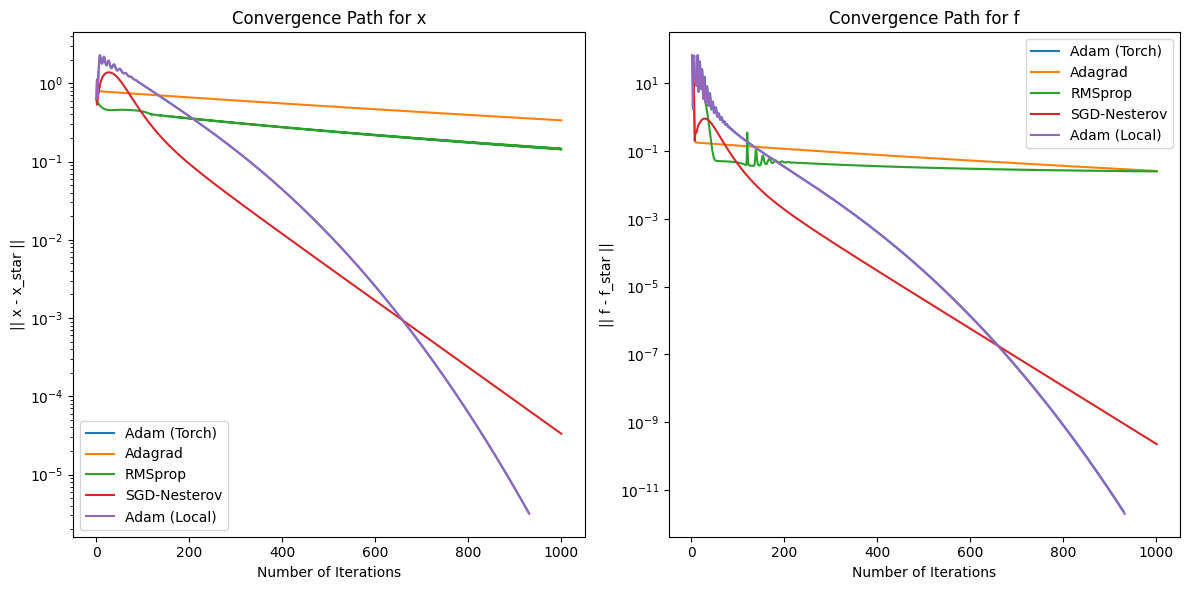

In [174]:
from scipy.stats import zscore

def plot_convergence(solutions, values, x_star, f_star, zscore_threshold=5):
    plt.figure(figsize=(12, 6))

    # Plotting || x - x_star ||
    plt.subplot(1, 2, 1)
    for optim_name in solutions.keys():
        x_diff = np.linalg.norm(solutions[optim_name] - x_star, axis=1)
        
        # Remove outliers based on z-scores
        z_scores = zscore(x_diff)
        valid_indices = np.abs(z_scores) < zscore_threshold
        plt.plot(np.arange(1, len(x_diff) + 1)[valid_indices], x_diff[valid_indices], label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| x - x_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for x')

    # Plotting || f - f_star ||
    plt.subplot(1, 2, 2)
    for optim_name in solutions.keys():
        f_diff = np.abs(values[optim_name] - f_star)
        
        # Remove outliers based on z-scores
        z_scores = zscore(f_diff)
        valid_indices = np.abs(z_scores) < zscore_threshold
        plt.plot(np.arange(1, len(f_diff) + 1)[valid_indices], f_diff[valid_indices], label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('|| f - f_star ||')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for f')

    plt.tight_layout()  # Ensure proper layout
    plt.show()

solutions, values = optimize_function(
    x_init=x_init,
    loss_fn=rosenbrock_torch, f=rosen, f_grad=rosen_der,
    adam_local_kw={"lr": 1.},
    adam_torch_kw={"lr": 1.},
    adagrad_kw={"lr": 1.},
    rmsprop_kw={"lr": 1e-2, "alpha": 0.9},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.95, "dampening": 0}
)
x_star = np.array([1, 1])
f_star = 0.0
plot_convergence(solutions, values, x_star, f_star)

## Comparison

### Quadratic Function (good conditioning)

In [214]:
quad_1, quad_1_prime = mk_quad(epsilon=0.98)
quad_1_torch, _ = mk_quad_torch(epsilon=0.98)
best_params = tune_params_wrap(x_init=x_init, x_star=[0, 0], f_star=0.0, loss_fn=quad_1_torch)
best_params

{'Adam (Torch)': {'lr': 0.1, 'beta1': 0.8844444444444445},
 'SGD-Nesterov': {'lr': 10.0, 'momentum': 0.1},
 'RMSprop': {'lr': 10.0, 'alpha': 0.99},
 'Adagrad': {'lr': 10.0}}

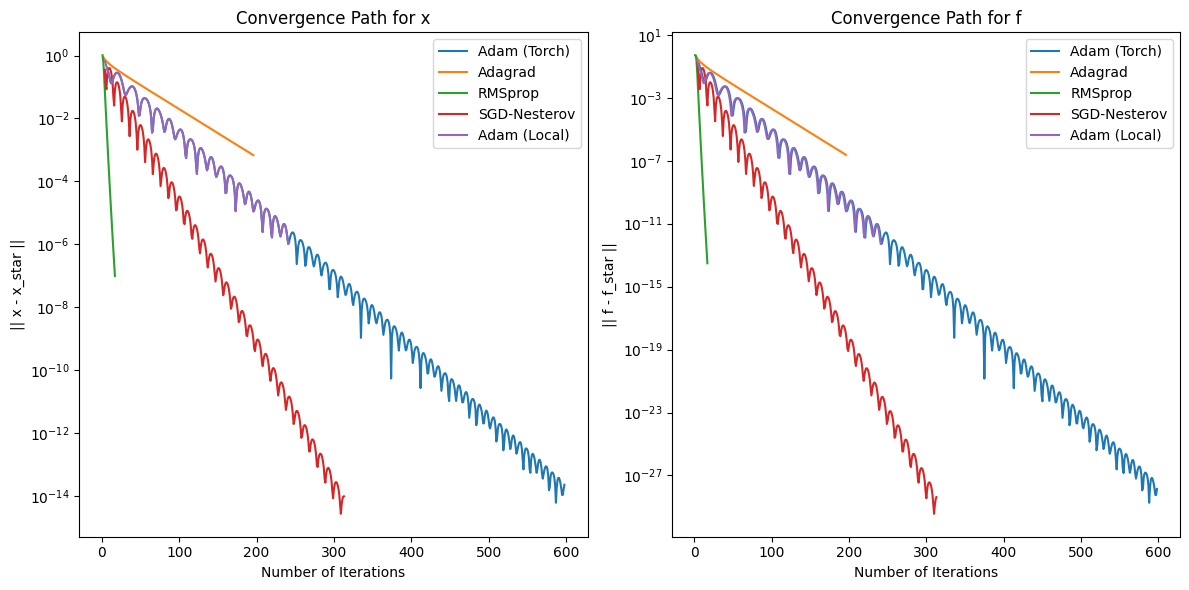

In [234]:
sols_quad1, vals_quad1 = optimize_function(
    x_init=x_init,
    loss_fn=quad_1_torch, f=quad_1, f_grad=quad_1_prime,
    adam_local_kw={"lr": 1e-1, "beta1": 0.9},
    adam_torch_kw={"lr": 1e-1},
    adagrad_kw={"lr": 1e-1},
    rmsprop_kw={"lr": 1e-1, "alpha": 0.99},
    sgd_nesterov_kw={"lr": 1e-1, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

x_star, f_star = np.array([0, 0]), 0.0
plot_convergence(sols_quad1, vals_quad1, x_star, f_star)

### Quadratic Function (bad conditioning)

In [238]:
quad_2, quad_2_prime = mk_quad(epsilon=0.98)
quad_2_torch, _ = mk_quad_torch(epsilon=0.98)
best_params = tune_params_wrap(x_init=x_init, x_star=[0, 0], f_star=0.0, loss_fn=quad_2_torch)
best_params

{'Adam (Torch)': {'lr': 0.1, 'beta1': 0.8844444444444445},
 'SGD-Nesterov': {'lr': 10.0, 'momentum': 0.1},
 'RMSprop': {'lr': 10.0, 'alpha': 0.99},
 'Adagrad': {'lr': 10.0}}

In [236]:
quad_2, quad_2_prime = mk_quad(epsilon=0.02)
quad_2_torch, _ = mk_quad_torch(epsilon=0.02)
sols_quad2, vals_quad2 = optimize_function(
    x_init=x_init,
    loss_fn=quad_2_torch, f=quad_2, f_grad=quad_2_prime,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

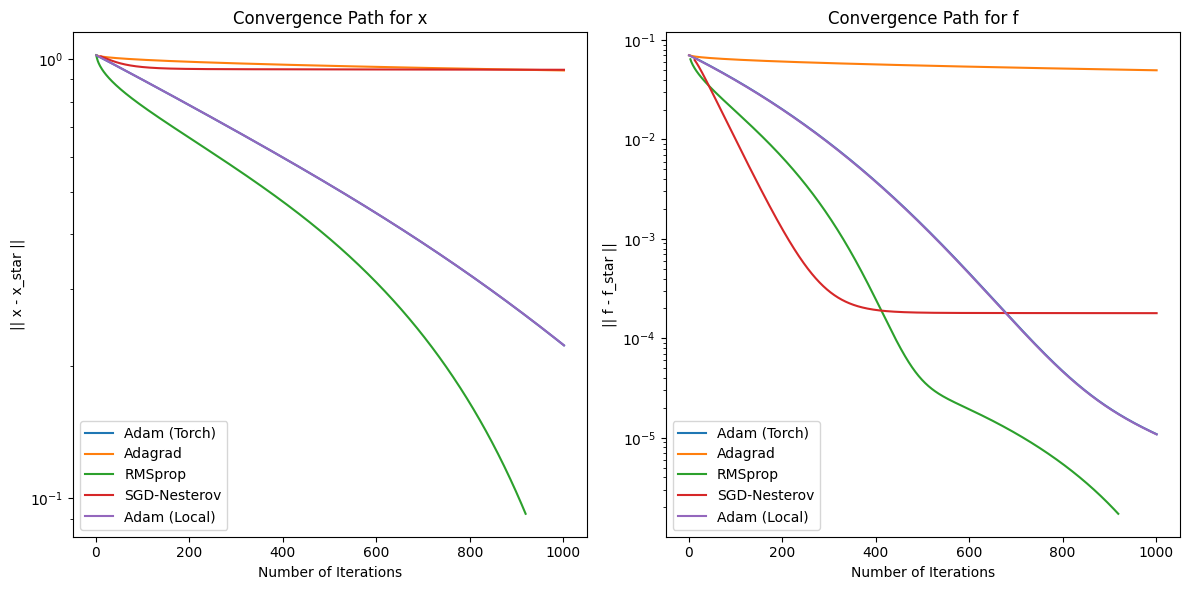

In [237]:
x_star, f_star = np.array([0, 0]), 0.0
plot_convergence(sols_quad2, vals_quad2, x_star, f_star)

### Non-Convex Gaussian Kernel 

In [ ]:
gauss, gauss_prime = mk_gauss(epsilon=1.4)
gauss_torch, _ = mk_quad_torch(epsilon=1.4)
sols_gauss, vals_gauss = optimize_function(
    loss_fn=gauss_torch, f=gauss, f_grad=gauss_prime,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

### Rosenbrock Function (flat region)

In [194]:
sols_rosen, vals_rosen = optimize_function(
    x_init=x_init,
    loss_fn=rosenbrock_torch, f=rosen, f_grad=rosen_der,
    adam_local_kw={"lr": 1., "beta1": 0.9, "beta2": 0.999},
    adam_torch_kw={"lr": 1.},
    adagrad_kw={"lr": 1.},
    rmsprop_kw={"lr": 1e-2, "alpha": 0.9},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.95, "dampening": 0}
)


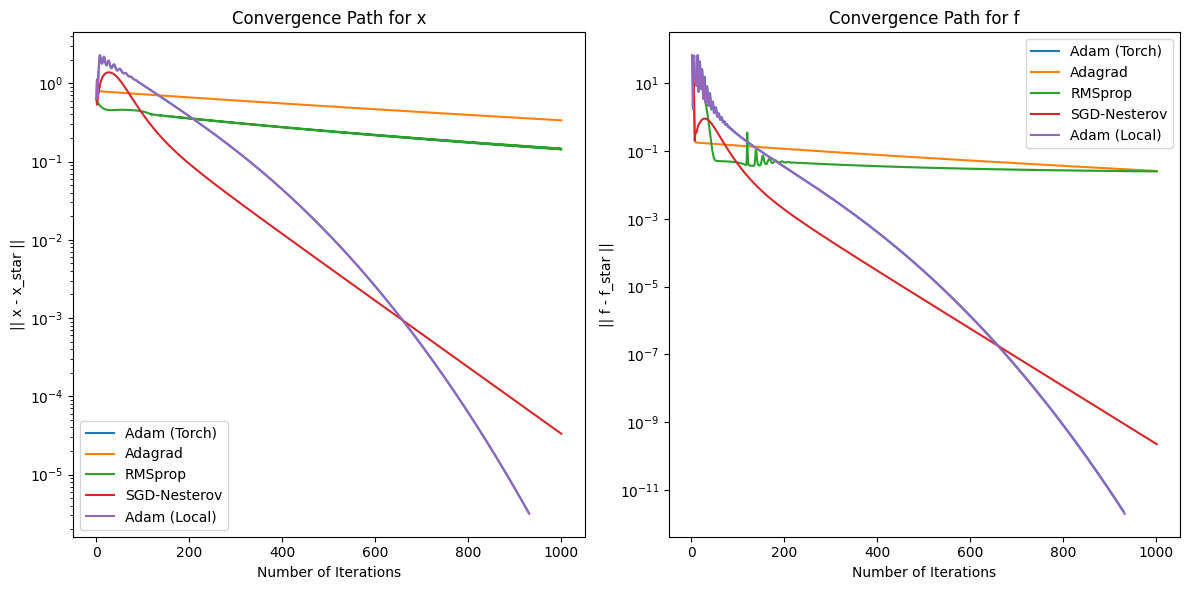

In [195]:
x_star, f_star = np.array([1, 1]), 0.0
plot_convergence(sols_rosen, vals_rosen, x_star, f_star)

### Eggholder (local minima)

In [13]:
eggholder, eggholder_prime = mk_eggholder()
eggholder_torch, _ = mk_quad_torch(epsilon=1.4)
sols_eggholder, vals_eggholder = optimize_function(
    loss_fn=eggholder_torch, f=eggholder, f_grad=eggholder_prime,
    adam_local_kw={"lr": 1e-3},
    adam_torch_kw={"lr": 1e-3},
    adagrad_kw={"lr": 1e-3},
    rmsprop_kw={"lr": 1e-3},
    sgd_nesterov_kw={"lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}
)

In [ ]:
x_star, f_star = np.array([1, 1]), 0.0
plot_convergence(sols_eggholder, vals_eggholder, x_star, f_star)